In [1]:
#!pip install matplotlib

In [2]:
import pandas as pd
import matplotlib.pyplot as plt

In [3]:
filepath = f'dataset.csv'
df = pd.read_csv(filepath)

## EDA

In [4]:
df

,sentence,category
0,"Auxílio-Doença Previdenciário, Benefícios em E...",orgão público
1,"PAGAR TODAS AS CONTAS EM ATRASO R$1.290,90.",finanças
2,Então encontraremos na próxima aula.,educação
3,Veja os resultados da categoria de ofertas do ...,indústrias
4,"Além disso, a embalagem é reutilizável e 100% ...","indústrias,varejo"
...,...,...
516,"Selecione o local de estudo, curso sem encontr...",educação
517,ESTUDANTES DA REDE MUNICIPAL VOLTAM ÀS AULAS E...,"educação,orgão público"
518,Empresas e órgãos públicos,orgão público
519,DGE – Departamento de Gestão Estratégica Metas...,orgão público


<AxesSubplot: >

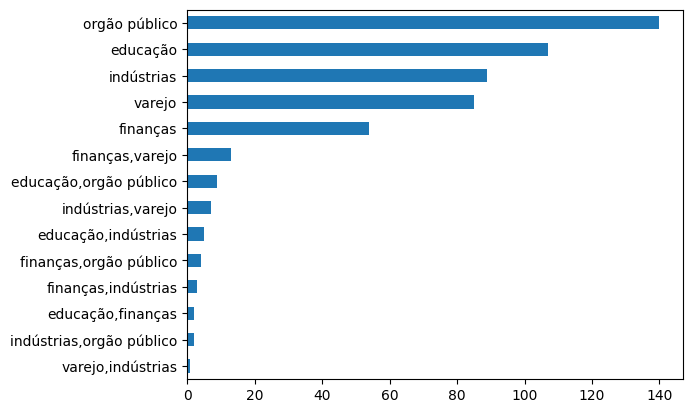

In [5]:
df.category.value_counts().sort_values().plot(kind = 'barh')

Algumas das categorias são coletivas, possuindo 2 classificações no máximo por texto, para solucionarmos esse problema iremos separar as categorias individuais

In [6]:
dummies = df['category'].str.get_dummies(sep=',')
df[dummies.columns] = dummies

Feito isso temos 5 colunas com 0s e 1s indicando se aquela sentença pertence a classe correspondente [1 para sim e 0 para não] - Esse método é chamado de **One-hot-encoding**

In [7]:
df.head(5)

,sentence,category,educação,finanças,indústrias,orgão público,varejo
0,"Auxílio-Doença Previdenciário, Benefícios em E...",orgão público,0,0,0,1,0
1,"PAGAR TODAS AS CONTAS EM ATRASO R$1.290,90.",finanças,0,1,0,0,0
2,Então encontraremos na próxima aula.,educação,1,0,0,0,0
3,Veja os resultados da categoria de ofertas do ...,indústrias,0,0,1,0,0
4,"Além disso, a embalagem é reutilizável e 100% ...","indústrias,varejo",0,0,1,0,1


Removemos os caracteres especiais das colunas

In [8]:
df.columns = df.columns.str.normalize('NFKD').str.encode('ascii', errors='ignore').str.decode('utf-8')
df.columns

Index(['sentence', 'category', 'educacao', 'financas', 'industrias',
       'orgao publico', 'varejo'],
      dtype='object')

Iremos remover a coluna *category*, não precisamos mais dela no momento

In [9]:
df.drop(columns=['category'], inplace=True)
df.head(5)

,sentence,educacao,financas,industrias,orgao publico,varejo
0,"Auxílio-Doença Previdenciário, Benefícios em E...",0,0,0,1,0
1,"PAGAR TODAS AS CONTAS EM ATRASO R$1.290,90.",0,1,0,0,0
2,Então encontraremos na próxima aula.,1,0,0,0,0
3,Veja os resultados da categoria de ofertas do ...,0,0,1,0,0
4,"Além disso, a embalagem é reutilizável e 100% ...",0,0,1,0,1


In [10]:
df.apply(pd.Series.value_counts)

,sentence,educacao,financas,industrias,orgao publico,varejo
0,NaN,398.0,445.0,414.0,366.0,415.0
1,NaN,123.0,76.0,107.0,155.0,106.0
Compre na web e saia com dinheiro no bolso!,1.0,NaN,NaN,NaN,NaN,NaN
O seu carrinho já tem 17 itens.,1.0,NaN,NaN,NaN,NaN,NaN
Temos preços especiais e retirada na loja.,1.0,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...
Você só pagará a tarifa por este serviço uma vez por mês.,1.0,NaN,NaN,NaN,NaN,NaN
programa de aprendizagem,1.0,NaN,NaN,NaN,NaN,NaN
É só ir ao caixa eletrônico do Itaú mais próximo com o seu cartão da conta corrente,1.0,NaN,NaN,NaN,NaN,NaN
É uma forma do investidor se programar para a realização dos seus objetivos.,1.0,NaN,NaN,NaN,NaN,NaN


Quantidade de valor por classe em estudo

<AxesSubplot: >

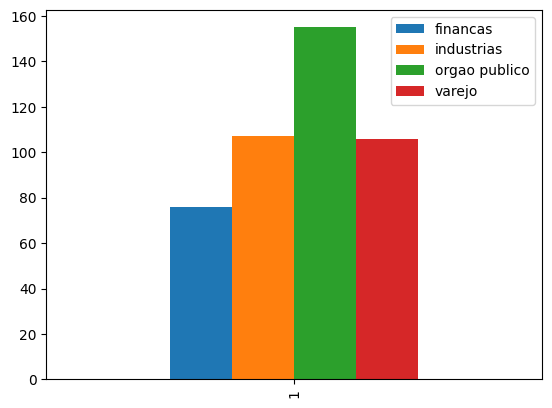

In [11]:
df.iloc[:,-4:].apply(pd.Series.value_counts).tail(1).plot(kind='bar')


## Tratamento do Texto e Processamento de Linguagem Natural

Nesta seção iremos tratar o texto de nosso dataset e transforma-lo em um padrão no qual poderemos gerar um classificador multi-label

In [12]:
#!pip install nltk

In [13]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score
from sklearn.multiclass import OneVsRestClassifier
import nltk

Estamos importando as stopwords (preposições) que atrapalham nosso processamento e modelagem

In [14]:
nltk.download('stopwords')
stopwords = nltk.corpus.stopwords.words('portuguese')
stopwords[:5]

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\victo\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


['a', 'à', 'ao', 'aos', 'aquela']

In [15]:
#Não há missing data in sentence
df.sentence.isna().sum()

0

In [16]:
import re
def clean_text(data):
    data['text_without_stopwords'] = data['sentence'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stopwords)])\
        .lower().encode('ascii', errors='ignore').decode('utf-8'))    

    return data

In [17]:
#!pip install unidecode

In [18]:
import re
import unidecode

def clean_text(data):
    data['text_without_stopwords'] = data['sentence'].apply(lambda x:unidecode.unidecode(re.sub(r'[.,"\'-?:!;]', ' ', ' '.\
        join([word for word in x.split() if word not in (stopwords)])).lower()))    

    return data

In [19]:
df_clean = clean_text(df)

In [20]:
df_clean.drop(columns=["sentence"], inplace=True)
df_clean

,educacao,financas,industrias,orgao publico,varejo,text_without_stopwords
0,0,0,0,1,0,auxilio doenca previdenciario beneficios espe...
1,0,1,0,0,0,pagar todas as contas em atraso r$
2,1,0,0,0,0,entao encontraremos proxima aula
3,0,0,1,0,0,veja resultados categoria ofertas novo modelo ...
4,0,0,1,0,1,alem disso embalagem reutilizavel % recicl...
...,...,...,...,...,...,...
516,1,0,0,0,0,selecione local estudo curso encontros presen...
517,1,0,0,1,0,estudantes da rede municipal voltam as aulas e...
518,0,0,0,1,0,empresas orgaos publicos
519,0,0,0,1,0,dge - departamento gestao estrategica metas na...


Após limparmos o texto de stop words e deixa-lo em lowercase utilizaremos a ferramenta do TfidfVectorizer, o qual transformará as palavras do corpus (texto de sentence) em vetores baseado na fre quência em que as palavras são repetidas no texto

Aqui esta um exemplo de aplicação:


In [21]:
df_clean.head(3)

,educacao,financas,industrias,orgao publico,varejo,text_without_stopwords
0,0,0,0,1,0,auxilio doenca previdenciario beneficios espe...
1,0,1,0,0,0,pagar todas as contas em atraso r$
2,1,0,0,0,0,entao encontraremos proxima aula


In [22]:
cleanTrain, cleanTest = train_test_split(df_clean, random_state=42, test_size=0.33, shuffle=True)

c:\Users\victo\anaconda3\envs\dev\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


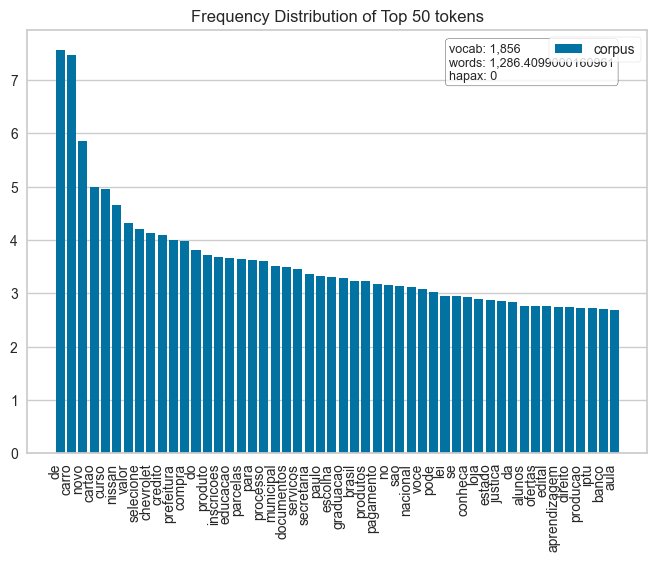

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


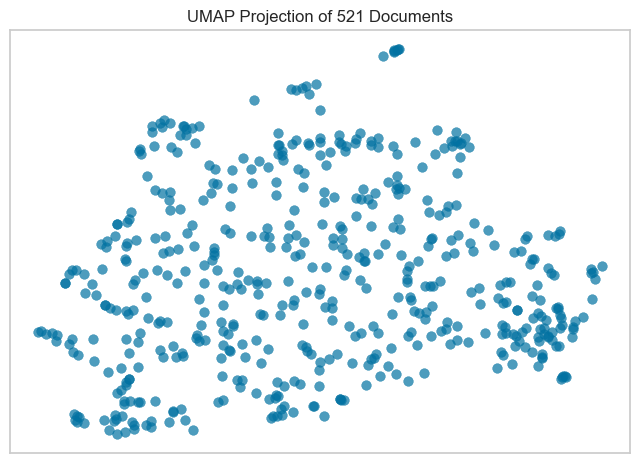

In [36]:
from yellowbrick.text import FreqDistVisualizer
from sklearn.feature_extraction.text import CountVectorizer

vectorizer = TfidfVectorizer()
vector_train_text = vectorizer.fit_transform(df_clean["text_without_stopwords"])
#vector_test_text =  vectorizer.fit_transform(cleanTest["text_without_stopwords"])
features = vectorizer.get_feature_names()

visualizer = FreqDistVisualizer(features=features, orient='v')
visualizer.fit(vector_train_text)
visualizer.show()

from yellowbrick.text import UMAPVisualizer

umap = UMAPVisualizer(metric="cosine")
umap.fit(vector_train_text)
umap.show()

vector_test_text =  vectorizer.fit_transform(cleanTest["text_without_stopwords"])

In [44]:
df_clean.iloc[ : , :5].values

array([[0, 0, 0, 1, 0],
       [0, 1, 0, 0, 0],
       [1, 0, 0, 0, 0],
       ...,
       [0, 0, 0, 1, 0],
       [0, 0, 0, 1, 0],
       [0, 0, 0, 1, 0]], dtype=int64)

In [101]:


X_train, X_test, y_train, y_test = train_test_split(df['text_without_stopwords'], df_clean.iloc[ : , :5].values, random_state = 32, test_size=0.1)

tfidf = TfidfVectorizer(sublinear_tf= True, 
                       norm= 'l2', 
                       ngram_range= (1,2))


X_train_counts = tfidf.fit_transform(X_train)
X_test_counts = tfidf.transform(X_test)

## Modelagem

Nesta etapa iremos criar um Pipeline aplicar um modelo classificador no nosso conjunto de dados
Inicialmente iremos realizar multi classificações binárias utilizando modelos mais simples, a seguir iremos partir para um modelo mais complexto de classificação multilabel

### Multi-classificação binária

In [25]:
categories = df.columns[0:5]
categories

Index(['educacao', 'financas', 'industrias', 'orgao publico', 'varejo'], dtype='object')

Separando nosso conjunto de treino e teste

In [26]:
train, test = train_test_split(df, random_state=42, test_size=0.33, shuffle=True)

In [27]:
X_train = train.text_without_stopwords
X_test = test.text_without_stopwords

In [28]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline


NB_pipeline = Pipeline([
                ('tfidf', TfidfVectorizer(stop_words=stopwords)),
                ('clf', OneVsRestClassifier(MultinomialNB(
                    fit_prior=True, class_prior=None))),
            ])
for category in categories:
    print('Treinando a categoria {}...'.format(category))
    # train the model using X_dtm & y
    NB_pipeline.fit(X_train, train[category])
    # compute the testing accuracy
    prediction = NB_pipeline.predict(X_test)
    print('Test accuracy is {}'.format(accuracy_score(test[category], prediction)))


Treinando a categoria educacao...
Test accuracy is 0.7616279069767442
Treinando a categoria financas...
Test accuracy is 0.877906976744186
Treinando a categoria industrias...
Test accuracy is 0.8604651162790697
Treinando a categoria orgao publico...
Test accuracy is 0.872093023255814
Treinando a categoria varejo...
Test accuracy is 0.7790697674418605


In [29]:
X_test

507    tecnologia humana combina figura aluno  profes...
93       suas compras podem parceladas   x juros cartao 
6                                 veja condicoes compra 
245    atender clientes  manter limpeza loja  marcar ...
90     maquina lavar consul   kg branca  ciclo lavage...
                             ...                        
116    excelencia processos produtos  atraves envolvi...
45                      apresentacao   disciplina online
324          clique aqui ver processos relacionados trf 
16     temos ofertas promocoes imperdiveis  sempre co...
485                     sua cesta vazia  voltar compras 
Name: text_without_stopwords, Length: 172, dtype: object

### Classificação Multilabel

Vetorizando os valores textuais do nosso dataframe

In [98]:
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix, f1_score, precision_score, recall_score


# you initiated your model and fit X_train_counts and y_train
clf = ExtraTreesClassifier(n_estimators=1000, random_state=0)
clf.fit(X_train_counts, y_train)
# you predicted from your transformed fe

ExtraTreesClassifier(n_estimators=1000, random_state=0)

In [99]:
predicted_labels = clf.predict(X_test_counts)

In [ ]:
print(confusion_matrix(predicted_labels.argmax(axis=1), y_test.argmax(axis=1)))
print(f1_score(predicted_labels, y_test, average='micro'))
print(precision_score(predicted_labels, y_test, average='micro'))
print(recall_score(predicted_labels, y_test, average='micro'))

[[10  3  2  6  3]
 [ 0  4  1  1  1]
 [ 0  0  8  0  0]
 [ 1  0  1  3  1]
 [ 0  1  0  1  6]]
0.6105263157894737
0.5
0.7837837837837838


In [135]:
entrada = input()
singular = tfidf.transform(pd.Series([entrada]))
resultado = clf.predict(singular)


In [136]:
resultado

array([[0, 0, 0, 1, 0]], dtype=int64)

In [134]:
df_clean.iloc[:, 0:5].columns

Index(['educacao', 'financas', 'industrias', 'orgao publico', 'varejo'], dtype='object')